<a href="https://colab.research.google.com/github/hadinursalim/Bioinformatics/blob/main/Classification_of_Arrhythmia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install -q keras

# **Importing Libraries**

In [3]:
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import os
from keras.layers import Dropout
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')
from keras import layers
from keras.layers import Input, Dense, Dropout, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Embedding, Add
from keras.layers import Conv1D, GlobalAveragePooling1D, AveragePooling2D, MaxPooling2D, MaxPool1D, ZeroPadding1D, GlobalMaxPooling2D, GlobalAveragePooling2D, LSTM, SpatialDropout1D
from keras.models import Sequential, Model
from keras.preprocessing import image
from keras.utils.vis_utils import plot_model
from keras.applications.inception_v3 import InceptionV3
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from keras.layers.merge import concatenate

# **Dataset**

Pembuatan model pembelajaran mesin untuk mengklasifikasikan data detak jantung ke dalam kelas yang berbeda. Seperti yang diberikan dalam dataset, terdapat 5 kelas detak jantung yang berbeda sebagai [N:0, S:1, V:2 , F:3, Q:4]

* N: Denyut Normal
* S: Denyut Supraventricular
* V: Denyut Ventrikel
* F: Fusion Beats
* T: Ketukan Tidak Diketahui

In [4]:
#Dataset
train_df=pd.read_csv('/content/drive/MyDrive/Dataset ECG - MIT - BIH/mitbih_train.csv',header=None)
test_df=pd.read_csv('/content/drive/MyDrive/Dataset ECG - MIT - BIH/mitbih_test.csv',header=None)

In [5]:
train_df[187]=train_df[187].astype(int)
equilibre=train_df[187].value_counts()
print(equilibre)
train_df.shape

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


(87554, 188)

In [6]:
test_df[187]=test_df[187].astype(int)
equilibre=test_df[187].value_counts()
print(equilibre)
test_df.shape

0    18118
4     1608
2     1448
1      556
3      162
Name: 187, dtype: int64


(21892, 188)

# **Visualization**

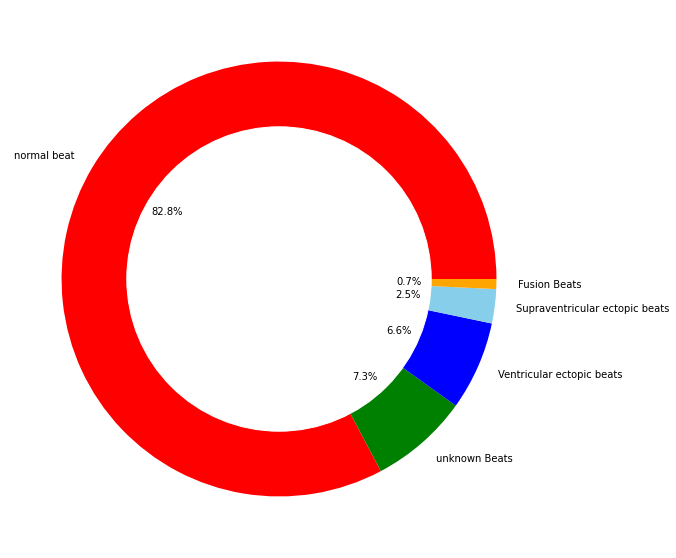

In [7]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['normal beat','unknown Beats','Ventricular ectopic beats','Supraventricular ectopic beats','Fusion Beats'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

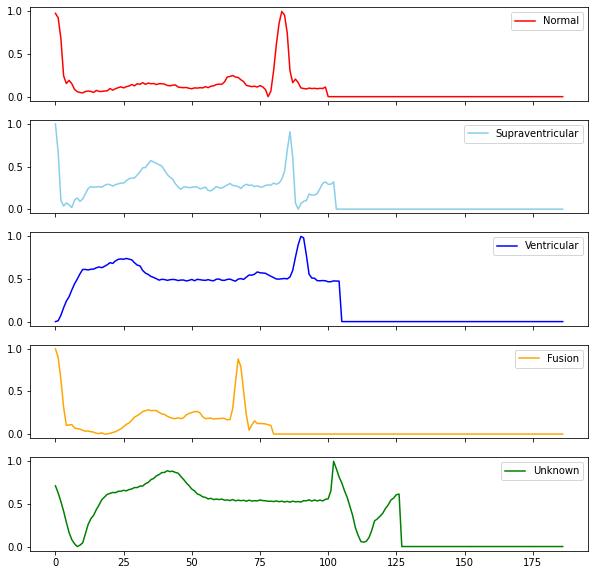

In [8]:
# plot ECG data belonging to each class label
label = ["Normal","Supraventricular","Ventricular",
         "Fusion","Unknown"]
color = ['red','skyblue','blue','orange','green']
fig, ax = plt.subplots(5, 1, sharex=True, sharey=True,figsize=(10,10))
for i, row in enumerate(ax):
    row.plot((train_df[train_df[187] == i].iloc[0])[:-1], label=label[i], color=color[i])
    row.legend()

# **Resample**

Dilakukan imbalance data dengan teknik **Resampling**

In [9]:
#resample
from sklearn.utils import resample
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [10]:
equilibre=train_df[187].value_counts()
print(equilibre)

0    20000
1    20000
2    20000
3    20000
4    20000
Name: 187, dtype: int64


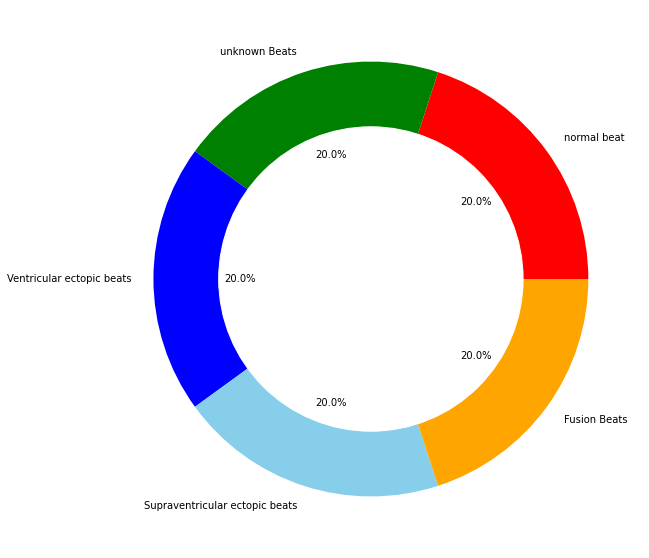

In [11]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['normal beat','unknown Beats','Ventricular ectopic beats','Supraventricular ectopic beats','Fusion Beats'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

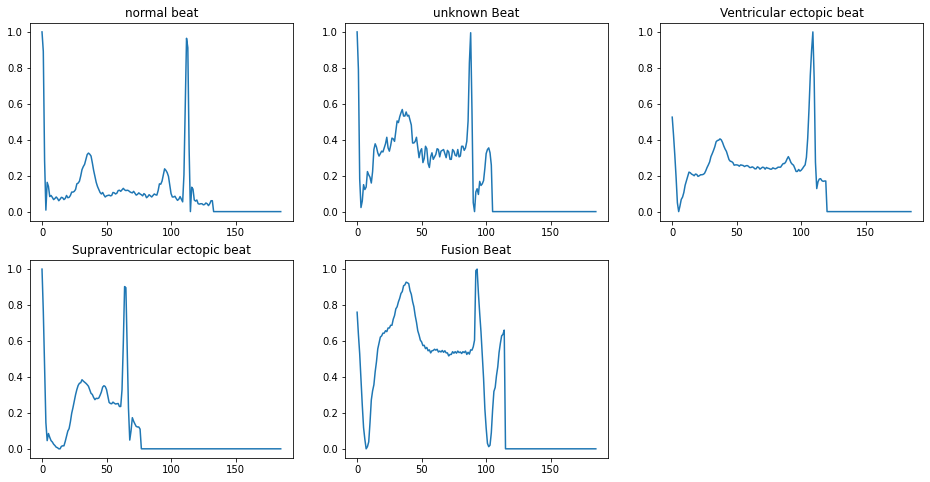

In [12]:
# randomly sampling from each class
c=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))
# plotting classes ECG
plt.figure(figsize=(16,8))
# normal
plt.subplot(2, 3, 1)  
plt.plot(c.iloc[0,:186])
plt.title('normal beat')
# unknown
plt.subplot(2, 3, 2)  
plt.plot(c.iloc[1,:186])
plt.title('unknown Beat')
# veb
plt.subplot(2, 3, 3)  
plt.plot(c.iloc[2,:186])
plt.title('Ventricular ectopic beat')
# seb
plt.subplot(2, 3, 4)  
plt.plot(c.iloc[3,:186])
plt.title('Supraventricular ectopic beat')
# fusion
plt.subplot(2, 3, 5)  
plt.plot(c.iloc[4,:186])
plt.title('Fusion Beat')
# show plot
plt.show()

# **Signal Hitmap**

In [13]:
def plot_hist(class_number,size,min_):
    img=train_df.loc[train_df[187]==class_number].values
    img=img[:,min_:size]
    img_flatten=img.flatten()

    final1=np.arange(min_,size)
    for i in range (img.shape[0]-1):
        tempo1=np.arange(min_,size)
        final1=np.concatenate((final1, tempo1), axis=None)
    print(len(final1))
    print(len(img_flatten))
    plt.hist2d(final1,img_flatten, bins=(80,80),cmap=plt.cm.jet)
    plt.show()

1300000
1300000


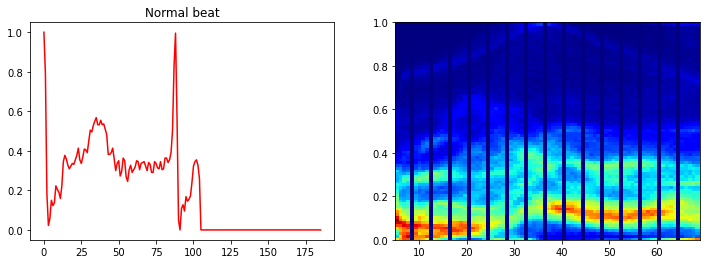

In [14]:
# Normal Beat
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)  
plt.plot(c.iloc[1,:186],color='red')
plt.title('Normal beat')
plt.subplot(1, 2, 2)  
plot_hist(0,70,5)

900000
900000


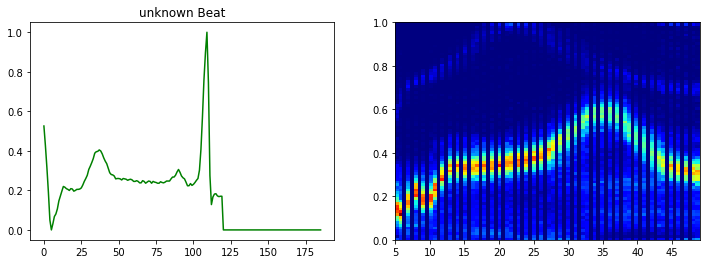

In [15]:
# unknown
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.plot(c.iloc[2,:186],color='green')
plt.title('unknown Beat')
plt.subplot(1, 2, 2)  
plot_hist(1,50,5)

600000
600000


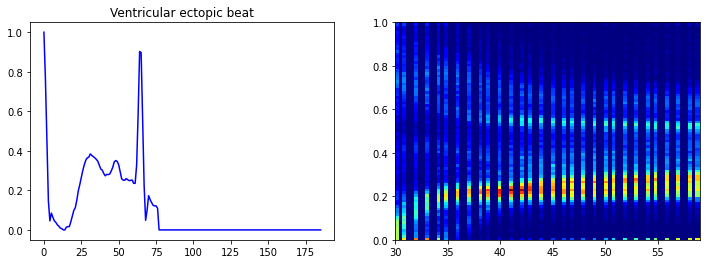

In [16]:
# veb
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)  
plt.plot(c.iloc[3,:186],color='blue')
plt.title('Ventricular ectopic beat')
plt.subplot(1, 2, 2) 
plot_hist(2,60,30)

700000
700000


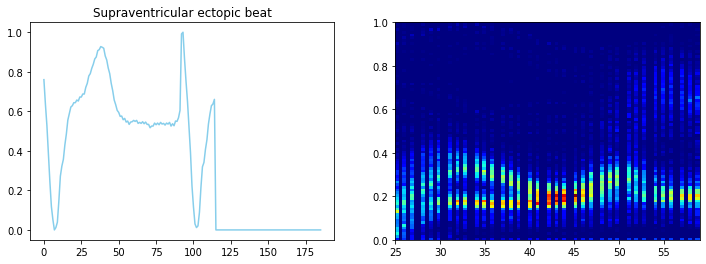

In [17]:
# seb
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1) 
plt.plot(c.iloc[4,:186],color='skyblue')
plt.title('Supraventricular ectopic beat')
plt.subplot(1, 2, 2) 
plot_hist(3,60,25)

640000
640000


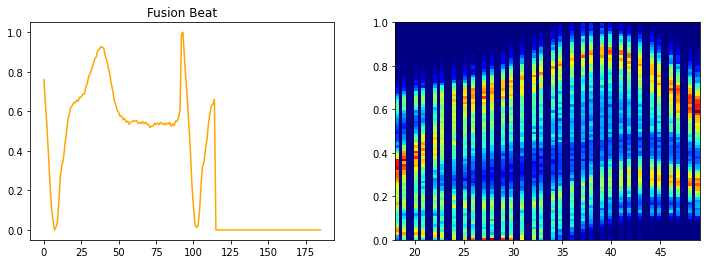

In [18]:
# fusion
plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)   
plt.plot(c.iloc[4,:186],color='orange')
plt.title('Fusion Beat')
plt.subplot(1, 2, 2) 
plot_hist(4,50,18)

# **Pretreaement**

# **Gaussian Method**

In [19]:
#Gaussian Method
def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.05,186)
    return (signal+noise)

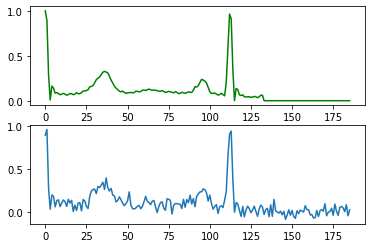

In [20]:
tempo=c.iloc[0,:186]
bruiter=add_gaussian_noise(tempo)

plt.subplot(2,1,1)
plt.plot(c.iloc[0,:186],color='green')

plt.subplot(2,1,2)
plt.plot(bruiter)

plt.show()

**Let's prepare a validation set which we will be useful for estimating model performance later**

In [21]:
from sklearn.model_selection import train_test_split
X, y = train_df.iloc[: , :-1], train_df.iloc[: , -1]
X, valX, y, valy= train_test_split(X,y,test_size=0.2)
testX, testy = test_df.iloc[: , :-1], test_df.iloc[: , -1]
y = to_categorical(y)
testy = to_categorical(testy)
valy=to_categorical(valy)

In [22]:
print("X shape=" +str(X.shape))
print("y shape=" +str(y.shape))
print("valX shape=" +str(valX.shape))
print("valy shape=" +str(valy.shape))
print("testX shape=" +str(testX.shape))
print("testy shape=" +str(testy.shape))

X shape=(80000, 187)
y shape=(80000, 5)
valX shape=(20000, 187)
valy shape=(20000, 5)
testX shape=(21892, 187)
testy shape=(21892, 5)


# **Data Modelling**

In [23]:
from keras.models import Model
from keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation , Dropout, BatchNormalization, AveragePooling1D, ZeroPadding1D
from keras import backend as K
from keras import Sequential
from keras.initializers import glorot_uniform

In [24]:
from sklearn.utils import shuffle
train_df[187] = train_df[187].astype('int32')
test_df[187] = test_df[187].astype('int32')
X_train = np.array(train_df.iloc[:, :187])
X_test = np.array(test_df.iloc[:, :187])
y_train = np.array(train_df[187])
y_test = np.array(test_df[187])
X_train, y_train = shuffle(X_train, y_train, random_state = 101)
X_test, y_test = shuffle(X_test, y_test, random_state = 101)
X_train = np.expand_dims(X_train, 2)
X_test = np.expand_dims(X_test, 2)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(100000, 187, 1)
(21892, 187, 1)
(100000, 5)
(21892, 5)


# **AlexNet**

In [25]:
alexNet_model=Sequential()

alexNet_model.add(Conv1D(filters=96, activation='relu', kernel_size=11, strides=4, input_shape=(187,1)))
alexNet_model.add(BatchNormalization())
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Conv1D(filters=256, kernel_size=5, padding='same', activation='relu'))
alexNet_model.add(BatchNormalization())
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Conv1D(filters=384, padding='same', kernel_size=3, activation='relu'))
alexNet_model.add(Conv1D(filters=384, kernel_size=3, activation='relu'))
alexNet_model.add(Conv1D(filters=256, kernel_size=3, activation='relu'))
alexNet_model.add(BatchNormalization())
alexNet_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

alexNet_model.add(Flatten())
alexNet_model.add(Dense(4096, activation='relu'))
alexNet_model.add(Dropout(0.4))
alexNet_model.add(Dense(4096, activation='relu'))
alexNet_model.add(Dropout(0.4))
alexNet_model.add(Dense(5, activation='softmax'))

In [26]:
alexNet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 45, 96)            1152      
                                                                 
 batch_normalization (BatchN  (None, 45, 96)           384       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 23, 96)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 23, 256)           123136    
                                                                 
 batch_normalization_1 (Batc  (None, 23, 256)          1024      
 hNormalization)                                                 
                                                        

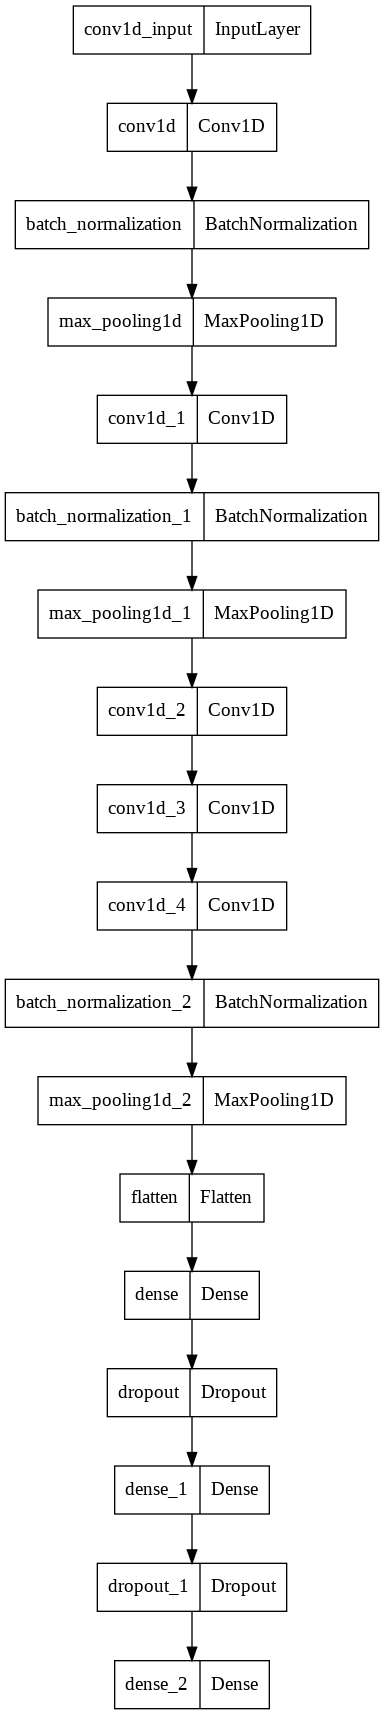

In [27]:
plot_model(alexNet_model)

In [28]:
alexNet_model.compile(
          loss = 'categorical_crossentropy',
          optimizer = 'Adam',metrics = ['accuracy']
                )

In [29]:
import keras
h = alexNet_model.fit(
      X_train,y_train,validation_data=(X_test, y_test),
                              epochs=25,batch_size=256,
                        callbacks = [
                              keras.callbacks.ModelCheckpoint('./model_{val_accuracy:.3f}.h5',
                              save_best_only = True,save_weights_only=False,
                              monitor='val_accuracy')
                          ])

Epoch 1/25
391/391 [==============================] - 28s 29ms/step - loss: 0.3674 - accuracy: 0.8913 - val_loss: 6.3289 - val_accuracy: 0.0254
Epoch 2/25
391/391 [==============================] - 11s 29ms/step - loss: 0.1096 - accuracy: 0.9608 - val_loss: 0.1503 - val_accuracy: 0.9484
Epoch 3/25
391/391 [==============================] - 12s 30ms/step - loss: 0.0752 - accuracy: 0.9744 - val_loss: 0.1663 - val_accuracy: 0.9506
Epoch 4/25
391/391 [==============================] - 10s 26ms/step - loss: 0.0568 - accuracy: 0.9812 - val_loss: 0.1619 - val_accuracy: 0.9461
Epoch 5/25
391/391 [==============================] - 12s 31ms/step - loss: 0.0520 - accuracy: 0.9832 - val_loss: 0.2154 - val_accuracy: 0.9361
Epoch 6/25
391/391 [==============================] - 12s 29ms/step - loss: 0.0434 - accuracy: 0.9863 - val_loss: 0.1251 - val_accuracy: 0.9646
Epoch 7/25
391/391 [==============================] - 11s 27ms/step - loss: 0.0380 - accuracy: 0.9883 - val_loss: 0.1579 - val_accuracy:

In [30]:
alexNet_model.save("./alexNet_model.h5")

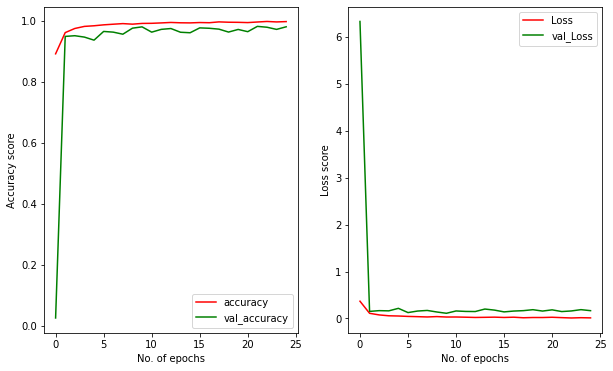

In [31]:
## Model accuracy score and loss visualization
accuracy = h.history['accuracy']
val_accuracy=h.history['val_accuracy']
loss=h.history['loss']
val_loss=h.history['val_loss']

epochs=range(len(accuracy)) #No. of epochs

plt.figure(figsize=(10,6))
ax0 = plt.subplot(1,2,1)
ax1 = plt.subplot(1,2,2)
ax0.plot(epochs,accuracy,'r',label='accuracy')
ax0.plot(epochs,val_accuracy,'g',label='val_accuracy')
ax0.legend()
ax0.set_xlabel('No. of epochs')
ax0.set_ylabel('Accuracy score')


ax1.plot(epochs,loss,'r',label='Loss')
ax1.plot(epochs,val_loss,'g',label='val_Loss')
ax1.set_xlabel('No. of epochs')
ax1.set_ylabel('Loss score')
ax1.legend()
plt.show()

**History**

In [32]:
#Validasi
alexNet_model.evaluate(valX,valy)

625/625 [==============================] - 3s 4ms/step - loss: 0.0062 - accuracy: 0.9984


[0.006212184205651283, 0.9983500242233276]

In [33]:
#Testing
alexNet_model.evaluate(X_test,y_test)

685/685 [==============================] - 3s 4ms/step - loss: 0.1658 - accuracy: 0.9799


[0.16583646833896637, 0.9799013137817383]

**Prediction on Validation and Testing Dataset**

In [34]:
import tensorflow as tf
y_pre_val = alexNet_model.predict(valX)
y_pred_val = np.zeros(y_pre_val.shape[0])
for i in range(y_pred_val.shape[0]):
    y_pred_val[i] = np.argmax(y_pre_val[i])
y_pred_val = tf.keras.utils.to_categorical(y_pred_val)

In [35]:
y_pre = alexNet_model.predict(X_test)
y_pred = np.zeros(y_pre.shape[0])
for i in range(y_pred.shape[0]):
    y_pred[i] = np.argmax(y_pre[i])
y_pred = tf.keras.utils.to_categorical(y_pred)

# **Results**

**For Validation Dataset**

In [36]:
from sklearn.metrics import classification_report,confusion_matrix,f1_score
print(classification_report(y_true=valy,y_pred=y_pred_val))
f1_score_per_class_validation = f1_score(y_true=valy,y_pred=y_pred_val,average=None) 
print("The f1-score per class: ",f1_score_per_class_validation)
print("The f1-score : ",f1_score(y_true=valy,y_pred=y_pred_val,average='weighted'))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4038
           1       1.00      1.00      1.00      3948
           2       1.00      1.00      1.00      4038
           3       1.00      1.00      1.00      4053
           4       1.00      1.00      1.00      3923

   micro avg       1.00      1.00      1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000
 samples avg       1.00      1.00      1.00     20000

The f1-score per class:  [0.99677499 0.99835506 0.99789422 0.99889094 0.99987256]
The f1-score :  0.9983492539031671


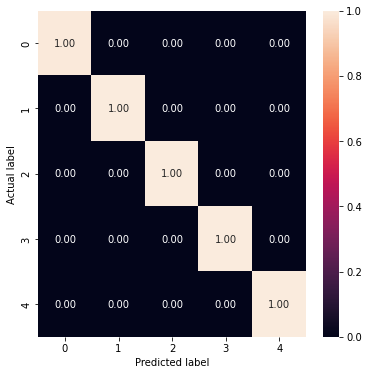

In [37]:
fig = plt.figure(figsize=(6, 6))
ax= plt.subplot()
cm = confusion_matrix(y_true=np.argmax(valy,axis=1),y_pred=np.argmax(y_pred_val,axis=1),normalize="true")
sns.heatmap(cm, annot=True, ax = ax, fmt = '.2f',)
ax.set_xlabel('Predicted label')
ax.set_ylabel('Actual label')
plt.show()

**For Testing Dataset**

In [38]:
print(classification_report(y_true=y_test,y_pred=y_pred))
f1_score_per_class_test = f1_score(y_true=y_test,y_pred=y_pred,average=None) 
print("The f1-score per class: ",f1_score_per_class_test)
print("The f1-score : ",f1_score(y_true=y_test,y_pred=y_pred,average='weighted'))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     18118
           1       0.76      0.86      0.81       556
           2       0.93      0.97      0.95      1448
           3       0.78      0.82      0.80       162
           4       0.98      0.99      0.99      1608

   micro avg       0.98      0.98      0.98     21892
   macro avg       0.89      0.93      0.91     21892
weighted avg       0.98      0.98      0.98     21892
 samples avg       0.98      0.98      0.98     21892

The f1-score per class:  [0.98938264 0.80675105 0.9479378  0.7987988  0.98547141]
The f1-score :  0.9803053913344242


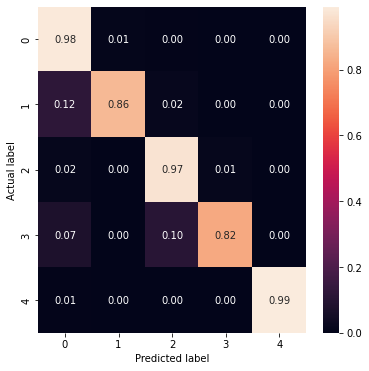

In [39]:
fig = plt.figure(figsize=(6, 6))
ax= plt.subplot()
cm = confusion_matrix(y_true=np.argmax(y_test,axis=1),y_pred=np.argmax(y_pred,axis=1),normalize="true")
sns.heatmap(cm, annot=True, ax = ax, fmt = '.2f')
ax.set_xlabel('Predicted label')
ax.set_ylabel('Actual label')
plt.show()

**Presisi Score**

In [40]:
#Validasi
from sklearn.metrics import precision_score
print("The precision score : ",precision_score(y_true=valy,y_pred=y_pred_val,average='weighted'))

The precision score :  0.9983505907830195


In [41]:
#Testing
print("The precision score : ",precision_score(y_true=y_test,y_pred=y_pred,average='weighted'))

The precision score :  0.9809677436321618


**Accuracy Score**

In [42]:
#Validasi
from sklearn.metrics import accuracy_score
print("The accuracy score : ",accuracy_score(y_true=valy,y_pred=y_pred_val))

The accuracy score :  0.99835


In [43]:
#Testing
print("The accuracy score : ",accuracy_score(y_true=y_test,y_pred=y_pred))

The accuracy score :  0.9799013338205738


# **VGG-16**

In [44]:
vgg_16_model=Sequential()

vgg_16_model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu',  input_shape=(187,1)))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Conv1D(filters=256, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Conv1D(filters=512, kernel_size=3, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Conv1D(filters=512, kernel_size=1, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(Conv1D(filters=512, kernel_size=1, activation='relu', padding='same'))
vgg_16_model.add(BatchNormalization())
vgg_16_model.add(MaxPool1D(pool_size=2, strides=2, padding='same'))

vgg_16_model.add(Flatten())
vgg_16_model.add(Dense(4096, activation='relu'))
vgg_16_model.add(Dropout(0.4))
vgg_16_model.add(Dense(4096, activation='relu'))
vgg_16_model.add(Dropout(0.4))
vgg_16_model.add(Dense(5, activation='softmax'))

In [45]:
vgg_16_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 187, 64)           256       
                                                                 
 batch_normalization_3 (Batc  (None, 187, 64)          256       
 hNormalization)                                                 
                                                                 
 conv1d_6 (Conv1D)           (None, 187, 64)           12352     
                                                                 
 batch_normalization_4 (Batc  (None, 187, 64)          256       
 hNormalization)                                                 
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 94, 64)           0         
 1D)                                                             
                                                      

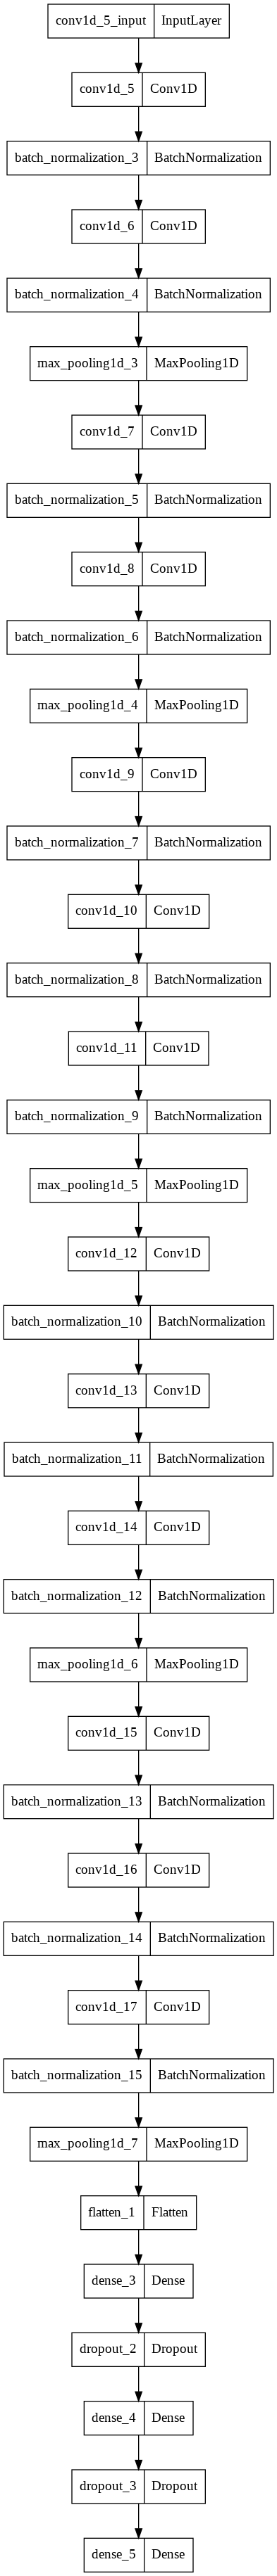

In [46]:
plot_model(vgg_16_model)

In [47]:
vgg_16_model.compile(
          loss = 'categorical_crossentropy',
          optimizer = 'Adam',metrics = ['accuracy']
                )

In [48]:
import keras
h = vgg_16_model.fit(
      X_train,y_train,validation_data=(X_test, y_test),
                              epochs=25,batch_size=256,
                        callbacks = [
                              keras.callbacks.ModelCheckpoint('./model_{val_accuracy:.3f}.h5',
                              save_best_only = True,save_weights_only=False,
                              monitor='val_accuracy')
                          ])

Epoch 1/25
391/391 [==============================] - 51s 119ms/step - loss: 0.3835 - accuracy: 0.9147 - val_loss: 5.1256 - val_accuracy: 0.0608
Epoch 2/25
391/391 [==============================] - 43s 110ms/step - loss: 0.0929 - accuracy: 0.9692 - val_loss: 0.1501 - val_accuracy: 0.9444
Epoch 3/25
391/391 [==============================] - 44s 112ms/step - loss: 0.0676 - accuracy: 0.9779 - val_loss: 0.0856 - val_accuracy: 0.9757
Epoch 4/25
391/391 [==============================] - 43s 110ms/step - loss: 0.0542 - accuracy: 0.9832 - val_loss: 0.0997 - val_accuracy: 0.9735
Epoch 5/25
391/391 [==============================] - 46s 117ms/step - loss: 0.0553 - accuracy: 0.9837 - val_loss: 0.1519 - val_accuracy: 0.9618
Epoch 6/25
391/391 [==============================] - 44s 111ms/step - loss: 0.0455 - accuracy: 0.9870 - val_loss: 0.1299 - val_accuracy: 0.9633
Epoch 7/25
391/391 [==============================] - 43s 111ms/step - loss: 0.0469 - accuracy: 0.9859 - val_loss: 0.1214 - val_ac

In [49]:
vgg_16_model.save("./vgg_16_model.h5")

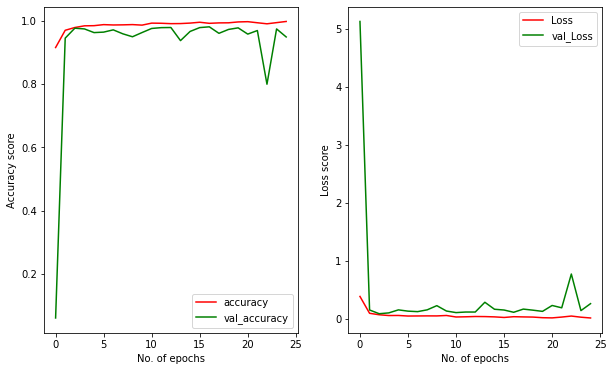

In [50]:
## Model accuracy score and loss visualization
accuracy = h.history['accuracy']
val_accuracy=h.history['val_accuracy']
loss=h.history['loss']
val_loss=h.history['val_loss']

epochs=range(len(accuracy)) #No. of epochs

plt.figure(figsize=(10,6))
ax0 = plt.subplot(1,2,1)
ax1 = plt.subplot(1,2,2)
ax0.plot(epochs,accuracy,'r',label='accuracy')
ax0.plot(epochs,val_accuracy,'g',label='val_accuracy')
ax0.legend()
ax0.set_xlabel('No. of epochs')
ax0.set_ylabel('Accuracy score')


ax1.plot(epochs,loss,'r',label='Loss')
ax1.plot(epochs,val_loss,'g',label='val_Loss')
ax1.set_xlabel('No. of epochs')
ax1.set_ylabel('Loss score')
ax1.legend()
plt.show()

**History**

In [51]:
#Validasi
vgg_16_model.evaluate(valX,valy)

625/625 [==============================] - 6s 8ms/step - loss: 0.1452 - accuracy: 0.9603


[0.1452149599790573, 0.9603000283241272]

In [52]:
#Testing
vgg_16_model.evaluate(X_test,y_test)

685/685 [==============================] - 6s 8ms/step - loss: 0.2591 - accuracy: 0.9481


[0.25909262895584106, 0.9480631947517395]

**Prediction on Validation and Testing Dataset**

In [53]:
import tensorflow as tf
y_pre_val = vgg_16_model.predict(valX)
y_pred_val = np.zeros(y_pre_val.shape[0])
for i in range(y_pred_val.shape[0]):
    y_pred_val[i] = np.argmax(y_pre_val[i])
y_pred_val = tf.keras.utils.to_categorical(y_pred_val)

In [54]:
y_pre = vgg_16_model.predict(X_test)
y_pred = np.zeros(y_pre.shape[0])
for i in range(y_pred.shape[0]):
    y_pred[i] = np.argmax(y_pre[i])
y_pred = tf.keras.utils.to_categorical(y_pred)

# **Results**

**For Validation Dataset**

In [55]:
from sklearn.metrics import classification_report,confusion_matrix,f1_score
print(classification_report(y_true=valy,y_pred=y_pred_val))
f1_score_per_class_validation = f1_score(y_true=valy,y_pred=y_pred_val,average=None) 
print("The f1-score per class: ",f1_score_per_class_validation)
print("The f1-score : ",f1_score(y_true=valy,y_pred=y_pred_val,average='weighted'))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      4038
           1       0.97      1.00      0.98      3948
           2       0.92      0.99      0.95      4038
           3       1.00      0.86      0.92      4053
           4       0.99      1.00      0.99      3923

   micro avg       0.96      0.96      0.96     20000
   macro avg       0.96      0.96      0.96     20000
weighted avg       0.96      0.96      0.96     20000
 samples avg       0.96      0.96      0.96     20000

The f1-score per class:  [0.94876195 0.98103792 0.95395598 0.92211755 0.99441908]
The f1-score :  0.95973806037758


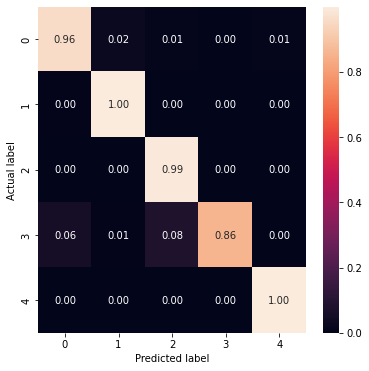

In [56]:
fig = plt.figure(figsize=(6, 6))
ax= plt.subplot()
cm = confusion_matrix(y_true=np.argmax(valy,axis=1),y_pred=np.argmax(y_pred_val,axis=1),normalize="true")
sns.heatmap(cm, annot=True, ax = ax, fmt = '.2f',)
ax.set_xlabel('Predicted label')
ax.set_ylabel('Actual label')
plt.show()

**For Testing Dataset**

In [57]:
print(classification_report(y_true=y_test,y_pred=y_pred))
f1_score_per_class_test = f1_score(y_true=y_test,y_pred=y_pred,average=None) 
print("The f1-score per class: ",f1_score_per_class_test)
print("The f1-score : ",f1_score(y_true=y_test,y_pred=y_pred,average='weighted'))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     18118
           1       0.44      0.90      0.59       556
           2       0.87      0.97      0.92      1448
           3       0.68      0.73      0.70       162
           4       0.91      0.99      0.95      1608

   micro avg       0.95      0.95      0.95     21892
   macro avg       0.78      0.91      0.83     21892
weighted avg       0.96      0.95      0.95     21892
 samples avg       0.95      0.95      0.95     21892

The f1-score per class:  [0.96986673 0.59478673 0.91975106 0.70238095 0.94649227]
The f1-score :  0.9533296065433107


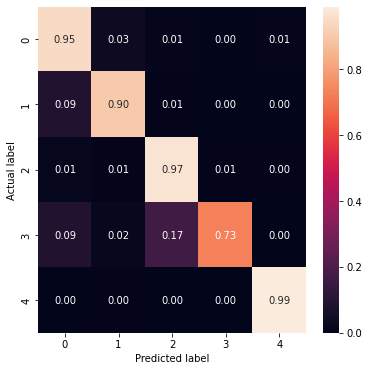

In [58]:
fig = plt.figure(figsize=(6, 6))
ax= plt.subplot()
cm = confusion_matrix(y_true=np.argmax(y_test,axis=1),y_pred=np.argmax(y_pred,axis=1),normalize="true")
sns.heatmap(cm, annot=True, ax = ax, fmt = '.2f')
ax.set_xlabel('Predicted label')
ax.set_ylabel('Actual label')
plt.show()

**Presisi Score**

In [59]:
#Validasi
from sklearn.metrics import precision_score
print("The precision score : ",precision_score(y_true=valy,y_pred=y_pred_val,average='weighted'))

The precision score :  0.9620440959302484


In [60]:
#Testing
print("The precision score : ",precision_score(y_true=y_test,y_pred=y_pred,average='weighted'))

The precision score :  0.9642085202860425


**Accuracy Score**

In [61]:
#Validasi
from sklearn.metrics import accuracy_score
print("The accuracy score : ",accuracy_score(y_true=valy,y_pred=y_pred_val))

The accuracy score :  0.9603


In [62]:
#Testing
print("The accuracy score : ",accuracy_score(y_true=y_test,y_pred=y_pred))

The accuracy score :  0.9480632194408917


# **ResNet**

In [63]:
n_obs, feature, depth = X_train.shape
batch_size = 256
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv1D(filters=F1, kernel_size=1, strides=1, padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=2, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv1D(filters=F2, kernel_size=f, strides=1, padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=2, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv1D(filters=F3, kernel_size=1, strides=1, padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=2, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [64]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv1D(filters=F1, kernel_size=1, strides=s, padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=2, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv1D(filters=F2, kernel_size=f, strides=1, padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=2, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv1D(filters=F3, kernel_size=1, strides=1, padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=2, name=bn_name_base + '2c')(X)

    X_shortcut = Conv1D(filters=F3, kernel_size=1, strides=s, padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=2, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [65]:
def ResNet(input_shape=(feature,depth)):

    X_input = Input(input_shape)

    X = ZeroPadding1D(3)(X_input)

    X = Conv1D(64, 7, strides=2, name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=2, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling1D(3, strides= 2)(X)

    X = convolutional_block(X, f=3, filters=[128, 128, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [128, 128, 256], stage=2, block='b')
    X = identity_block(X, 3, [128, 128, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling1D(pool_size= 2, padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet')

    return model

In [66]:
base_model = ResNet(input_shape=(feature,depth))

headModel = base_model.output
headModel = Flatten()(headModel)
headModel=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense(5,activation='softmax', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)

In [67]:
ResNet_model = Model(inputs=base_model.input, outputs=headModel)
ResNet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 187, 1)]     0           []                               
                                                                                                  
 zero_padding1d (ZeroPadding1D)  (None, 193, 1)      0           ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv1D)                 (None, 94, 64)       512         ['zero_padding1d[0][0]']         
                                                                                                  
 bn_conv1 (BatchNormalization)  (None, 94, 64)       256         ['conv1[0][0]']                  
                                                                                              

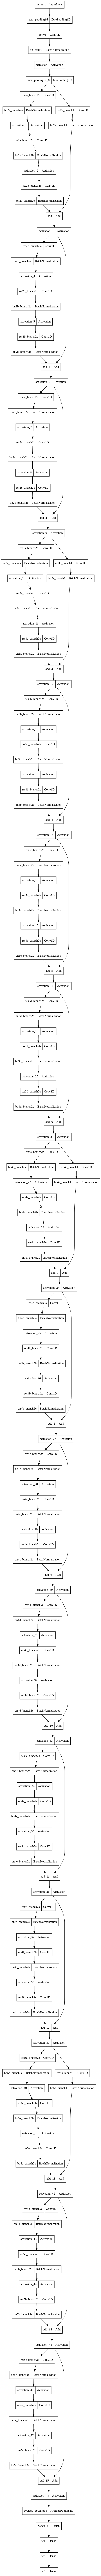

In [68]:
plot_model(ResNet_model)

In [69]:
ResNet_model.compile(
          loss = 'categorical_crossentropy',
          optimizer = 'Adam',metrics = ['accuracy']
                )

In [70]:
import keras
h = ResNet_model.fit(
      X_train,y_train,validation_data=(valX,valy),
                              epochs=25,batch_size=256,
                        callbacks = [
                              keras.callbacks.ModelCheckpoint('./model_{val_accuracy:.3f}.h5',
                              save_best_only = True,save_weights_only=False,
                              monitor='val_accuracy')
                          ])

Epoch 1/25
391/391 [==============================] - 102s 219ms/step - loss: 0.3410 - accuracy: 0.8966 - val_loss: 2.8580 - val_accuracy: 0.2176
Epoch 2/25
391/391 [==============================] - 83s 212ms/step - loss: 0.0836 - accuracy: 0.9714 - val_loss: 0.0823 - val_accuracy: 0.9715
Epoch 3/25
391/391 [==============================] - 84s 214ms/step - loss: 0.0618 - accuracy: 0.9792 - val_loss: 0.0730 - val_accuracy: 0.9740
Epoch 4/25
391/391 [==============================] - 83s 212ms/step - loss: 0.0507 - accuracy: 0.9831 - val_loss: 0.0594 - val_accuracy: 0.9794
Epoch 5/25
391/391 [==============================] - 83s 212ms/step - loss: 0.0545 - accuracy: 0.9823 - val_loss: 0.1538 - val_accuracy: 0.9575
Epoch 6/25
391/391 [==============================] - 82s 210ms/step - loss: 0.2334 - accuracy: 0.9251 - val_loss: 0.1199 - val_accuracy: 0.9578
Epoch 7/25
391/391 [==============================] - 83s 212ms/step - loss: 0.0844 - accuracy: 0.9707 - val_loss: 0.0527 - val_a

In [71]:
ResNet_model.save("./ResNet_model.h5")

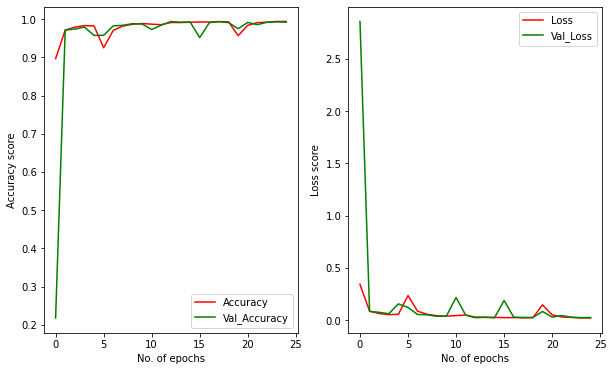

In [72]:
## Model accuracy score and loss visualization
accuracy = h.history['accuracy']
val_accuracy=h.history['val_accuracy']
loss=h.history['loss']
val_loss=h.history['val_loss']

epochs=range(len(accuracy)) #No. of epochs

plt.figure(figsize=(10,6))
ax0 = plt.subplot(1,2,1)
ax1 = plt.subplot(1,2,2)
ax0.plot(epochs,accuracy,'r',label='Accuracy')
ax0.plot(epochs,val_accuracy,'g',label='Val_Accuracy')
ax0.legend()
ax0.set_xlabel('No. of epochs')
ax0.set_ylabel('Accuracy score')


ax1.plot(epochs,loss,'r',label='Loss')
ax1.plot(epochs,val_loss,'g',label='Val_Loss')
ax1.set_xlabel('No. of epochs')
ax1.set_ylabel('Loss score')
ax1.legend()
plt.show()

**History**

In [73]:
#Validation
ResNet_model.evaluate(valX,valy)

625/625 [==============================] - 11s 15ms/step - loss: 0.0234 - accuracy: 0.9923


[0.02335071936249733, 0.9922500252723694]

In [74]:
#Testing
ResNet_model.evaluate(X_test,y_test)

685/685 [==============================] - 14s 17ms/step - loss: 0.1094 - accuracy: 0.9728


[0.10938376188278198, 0.9728211164474487]

**Prediction on Validation and Testing Dataset**

In [75]:
import tensorflow as tf
y_pre_val = ResNet_model.predict(valX)
y_pred_val = np.zeros(y_pre_val.shape[0])
for i in range(y_pred_val.shape[0]):
    y_pred_val[i] = np.argmax(y_pre_val[i])
y_pred_val = tf.keras.utils.to_categorical(y_pred_val)

In [76]:
y_pre = ResNet_model.predict(X_test)
y_pred = np.zeros(y_pre.shape[0])
for i in range(y_pred.shape[0]):
    y_pred[i] = np.argmax(y_pre[i])
y_pred = tf.keras.utils.to_categorical(y_pred)

# **Results**

**For Validation Dataset**

In [77]:
from sklearn.metrics import classification_report,confusion_matrix,f1_score
print(classification_report(y_true=valy,y_pred=y_pred_val))
f1_score_per_class_validation = f1_score(y_true=valy,y_pred=y_pred_val,average=None) 
print("The f1-score per class: ",f1_score_per_class_validation)
print("The f1-score : ",f1_score(y_true=valy,y_pred=y_pred_val,average='weighted'))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4038
           1       0.99      1.00      1.00      3948
           2       0.99      0.99      0.99      4038
           3       0.99      0.99      0.99      4053
           4       1.00      1.00      1.00      3923

   micro avg       0.99      0.99      0.99     20000
   macro avg       0.99      0.99      0.99     20000
weighted avg       0.99      0.99      0.99     20000
 samples avg       0.99      0.99      0.99     20000

The f1-score per class:  [0.98612144 0.99544765 0.99056604 0.9900234  0.99936281]
The f1-score :  0.992247825264134


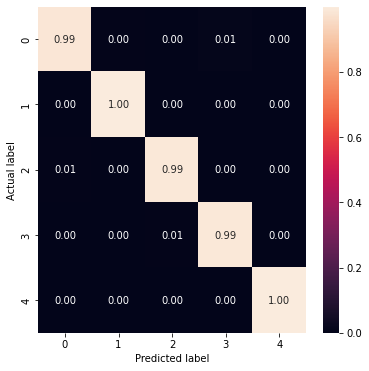

In [78]:
fig = plt.figure(figsize=(6, 6))
ax= plt.subplot()
cm = confusion_matrix(y_true=np.argmax(valy,axis=1),y_pred=np.argmax(y_pred_val,axis=1),normalize="true")
sns.heatmap(cm, annot=True, ax = ax, fmt = '.2f',)
ax.set_xlabel('Predicted label')
ax.set_ylabel('Actual label')
plt.show()

**For Testing Dataset**

In [79]:
print(classification_report(y_true=y_test,y_pred=y_pred))
f1_score_per_class_test = f1_score(y_true=y_test,y_pred=y_pred,average=None) 
print("The f1-score per class: ",f1_score_per_class_test)
print("The f1-score : ",f1_score(y_true=y_test,y_pred=y_pred,average='weighted'))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     18118
           1       0.71      0.87      0.78       556
           2       0.94      0.94      0.94      1448
           3       0.49      0.86      0.62       162
           4       0.98      0.99      0.98      1608

   micro avg       0.97      0.97      0.97     21892
   macro avg       0.82      0.93      0.86     21892
weighted avg       0.98      0.97      0.97     21892
 samples avg       0.97      0.97      0.97     21892

The f1-score per class:  [0.9852888  0.77966102 0.94271912 0.62222222 0.9839407 ]
The f1-score :  0.9744650081088397


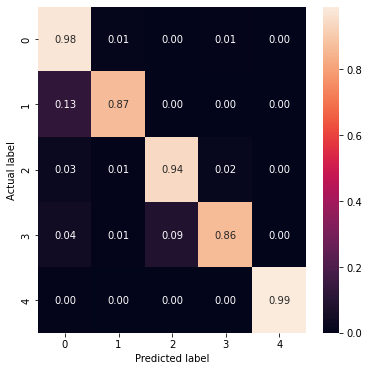

In [80]:
fig = plt.figure(figsize=(6, 6))
ax= plt.subplot()
cm = confusion_matrix(y_true=np.argmax(y_test,axis=1),y_pred=np.argmax(y_pred,axis=1),normalize="true")
sns.heatmap(cm, annot=True, ax = ax, fmt = '.2f')
ax.set_xlabel('Predicted label')
ax.set_ylabel('Actual label')
plt.show()

**Presisi Score**

In [81]:
#Validation
from sklearn.metrics import precision_score
print("The precision score : ",precision_score(y_true=valy,y_pred=y_pred_val,average='weighted'))

The precision score :  0.9922502760232477


In [82]:
#Testing
print("The precision score : ",precision_score(y_true=y_test,y_pred=y_pred,average='weighted'))

The precision score :  0.9774163091867015


**Accuracy Score**

In [83]:
#Validation
from sklearn.metrics import accuracy_score
print("The accuracy score : ",accuracy_score(y_true=valy,y_pred=y_pred_val))

The accuracy score :  0.99225


In [84]:
#Testing
print("The accuracy score : ",accuracy_score(y_true=y_test,y_pred=y_pred))

The accuracy score :  0.9728211218710031


# **Inception**

In [85]:
def inception_block(prev_layer):
    
    conv1=Conv1D(filters = 64, kernel_size = 1, activation='relu', padding = 'same')(prev_layer)
    
    conv3=Conv1D(filters = 64, kernel_size = 1, activation='relu', padding = 'same')(prev_layer)
    conv3=Conv1D(filters = 64, kernel_size = 3, activation='relu', padding = 'same')(conv3)
    
    conv5=Conv1D(filters = 64, kernel_size = 1, activation='relu', padding = 'same')(prev_layer)
    conv5=Conv1D(filters = 64, kernel_size = 5, activation='relu', padding = 'same')(conv5)
    
    pool= MaxPool1D(pool_size=3, strides=1, padding='same')(prev_layer)
    convmax=Conv1D(filters = 64, kernel_size = 1, activation='relu', padding = 'same')(pool)
    
    layer_out = concatenate([conv1, conv3, conv5, convmax], axis=1)
    return layer_out

In [86]:
def inception_model(input_shape):
    X_input=Input(input_shape)
    
    X = Conv1D(filters = 64, kernel_size = 7, activation='relu', padding = 'same')(X_input)
    X = MaxPool1D(pool_size=3, strides=2, padding='same')(X)
    
    X = Conv1D(filters = 64, kernel_size = 1, activation='relu', padding = 'same')(X)
    
    X = inception_block(X)
    X = inception_block(X)
    X = inception_block(X)
    X = inception_block(X)
    
    X = MaxPool1D(pool_size=7, strides=2, padding='same')(X)
    
    X = Flatten()(X)
    X = Dense(5,activation='softmax')(X)
    
    model = Model(inputs = X_input, outputs = X, name='Inception')
    
    return model

In [87]:
inception_model = inception_model(input_shape = (187,1))

In [88]:
inception_model.summary()

Model: "Inception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 187, 1)]     0           []                               
                                                                                                  
 conv1d_18 (Conv1D)             (None, 187, 64)      512         ['input_2[0][0]']                
                                                                                                  
 max_pooling1d_9 (MaxPooling1D)  (None, 94, 64)      0           ['conv1d_18[0][0]']              
                                                                                                  
 conv1d_19 (Conv1D)             (None, 94, 64)       4160        ['max_pooling1d_9[0][0]']        
                                                                                          

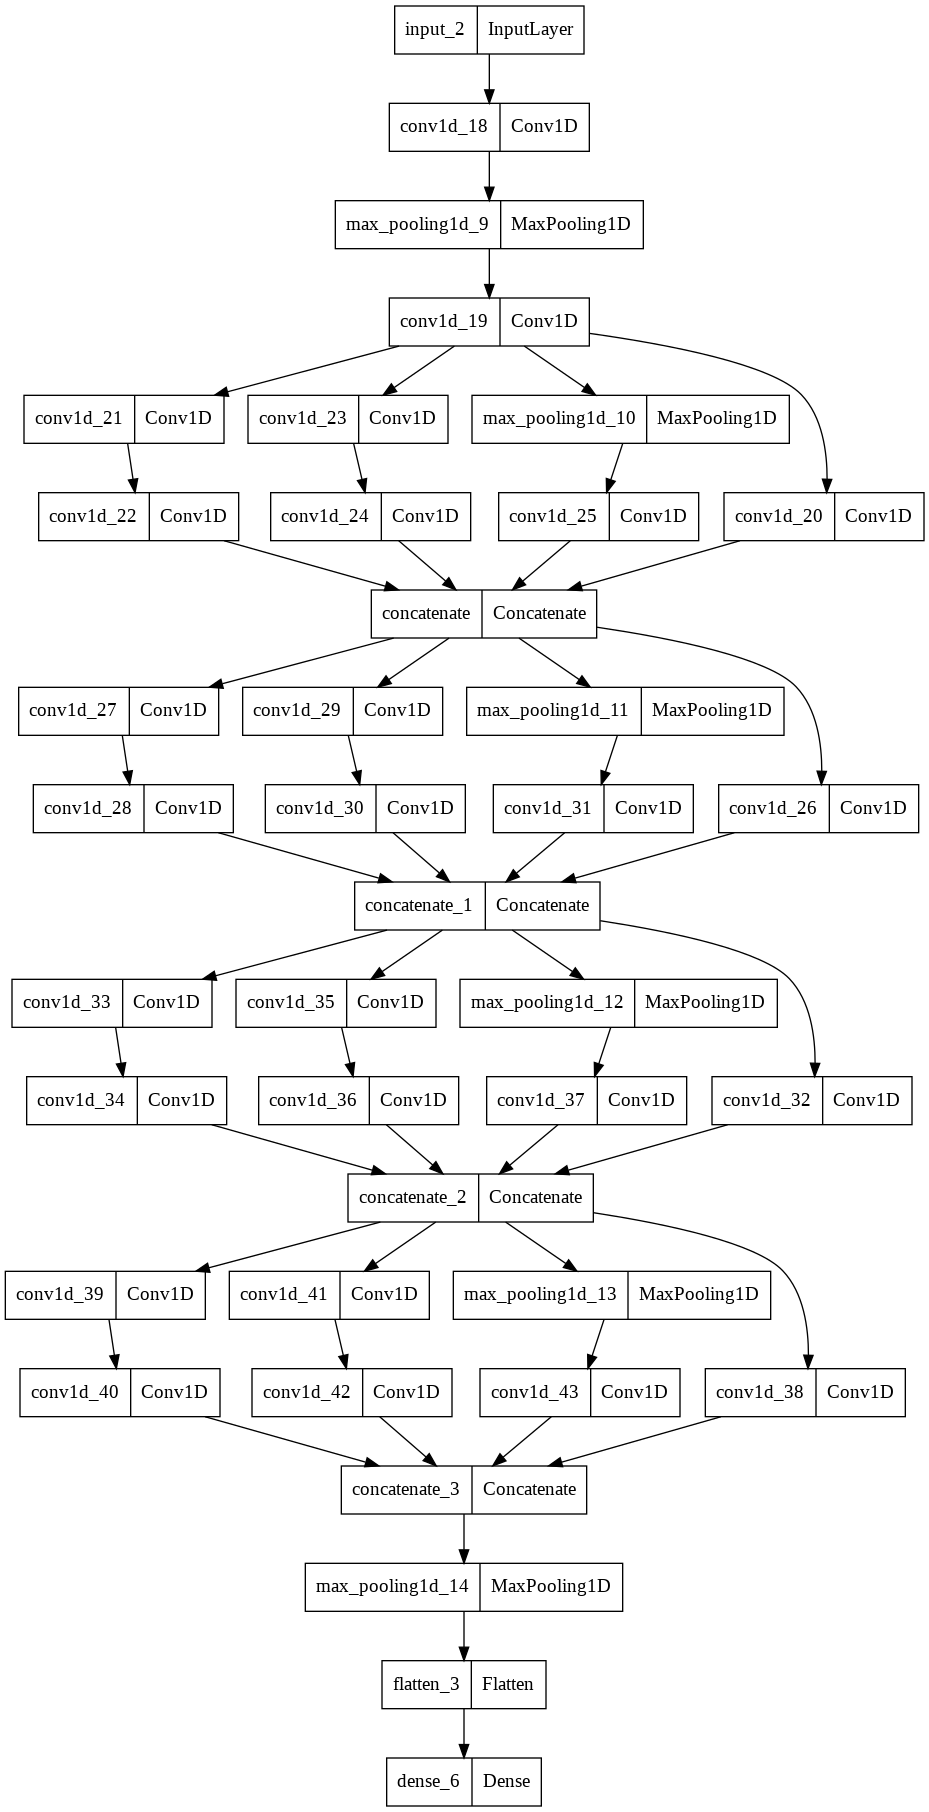

In [89]:
plot_model(inception_model)

In [90]:
inception_model.compile(
          loss = 'categorical_crossentropy',
          optimizer = 'Adam',metrics = ['accuracy']
                )

In [91]:
import keras
h = inception_model.fit(
      X_train,y_train,validation_data=(valX,valy),
                              epochs=25,batch_size=256,
                        callbacks = [
                              keras.callbacks.ModelCheckpoint('./model_{val_accuracy:.3f}.h5',
                              save_best_only = True,save_weights_only=False,
                              monitor='val_accuracy')
                          ])

Epoch 1/25
391/391 [==============================] - 306s 770ms/step - loss: 0.2990 - accuracy: 0.8905 - val_loss: 0.1216 - val_accuracy: 0.9554
Epoch 2/25
391/391 [==============================] - 300s 767ms/step - loss: 0.0977 - accuracy: 0.9666 - val_loss: 0.0749 - val_accuracy: 0.9744
Epoch 3/25
391/391 [==============================] - 299s 766ms/step - loss: 0.0579 - accuracy: 0.9813 - val_loss: 0.0413 - val_accuracy: 0.9870
Epoch 4/25
391/391 [==============================] - 299s 765ms/step - loss: 0.0422 - accuracy: 0.9864 - val_loss: 0.0432 - val_accuracy: 0.9866
Epoch 5/25
391/391 [==============================] - 299s 764ms/step - loss: 0.0330 - accuracy: 0.9895 - val_loss: 0.0216 - val_accuracy: 0.9934
Epoch 6/25
391/391 [==============================] - 298s 763ms/step - loss: 0.0279 - accuracy: 0.9912 - val_loss: 0.0198 - val_accuracy: 0.9932
Epoch 7/25
391/391 [==============================] - 298s 762ms/step - loss: 0.0234 - accuracy: 0.9927 - val_loss: 0.0320 -

In [92]:
inception_model.save("./inception_model.h5")

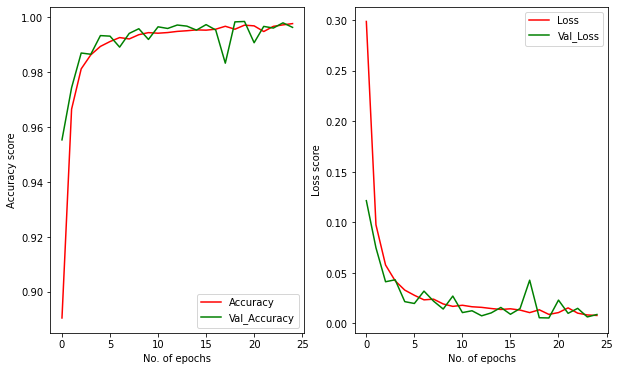

In [93]:
## Model accuracy score and loss visualization
accuracy = h.history['accuracy']
val_accuracy=h.history['val_accuracy']
loss=h.history['loss']
val_loss=h.history['val_loss']

epochs=range(len(accuracy)) #No. of epochs

plt.figure(figsize=(10,6))
ax0 = plt.subplot(1,2,1)
ax1 = plt.subplot(1,2,2)
ax0.plot(epochs,accuracy,'r',label='Accuracy')
ax0.plot(epochs,val_accuracy,'g',label='Val_Accuracy')
ax0.legend()
ax0.set_xlabel('No. of epochs')
ax0.set_ylabel('Accuracy score')


ax1.plot(epochs,loss,'r',label='Loss')
ax1.plot(epochs,val_loss,'g',label='Val_Loss')
ax1.set_xlabel('No. of epochs')
ax1.set_ylabel('Loss score')
ax1.legend()
plt.show()

**History**

In [94]:
#Validation
inception_model.evaluate(valX,valy)

625/625 [==============================] - 26s 40ms/step - loss: 0.0089 - accuracy: 0.9964


[0.008886691182851791, 0.996399998664856]

In [95]:
#Testing
inception_model.evaluate(X_test,y_test)

685/685 [==============================] - 26s 37ms/step - loss: 0.1553 - accuracy: 0.9759


[0.1552986353635788, 0.9759272933006287]

**Prediction on Validation and Testing Dataset**

In [96]:
import tensorflow as tf
y_pre_val = inception_model.predict(valX)
y_pred_val = np.zeros(y_pre_val.shape[0])
for i in range(y_pred_val.shape[0]):
    y_pred_val[i] = np.argmax(y_pre_val[i])
y_pred_val = tf.keras.utils.to_categorical(y_pred_val)

In [97]:
y_pre = inception_model.predict(X_test)
y_pred = np.zeros(y_pre.shape[0])
for i in range(y_pred.shape[0]):
    y_pred[i] = np.argmax(y_pre[i])
y_pred = tf.keras.utils.to_categorical(y_pred)

# **Results**

**For Validation Dataset**

In [98]:
from sklearn.metrics import classification_report,confusion_matrix,f1_score
print(classification_report(y_true=valy,y_pred=y_pred_val))
f1_score_per_class_validation = f1_score(y_true=valy,y_pred=y_pred_val,average=None) 
print("The f1-score per class: ",f1_score_per_class_validation)
print("The f1-score : ",f1_score(y_true=valy,y_pred=y_pred_val,average='weighted'))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4038
           1       1.00      0.99      1.00      3948
           2       1.00      1.00      1.00      4038
           3       0.99      1.00      1.00      4053
           4       1.00      1.00      1.00      3923

   micro avg       1.00      1.00      1.00     20000
   macro avg       1.00      1.00      1.00     20000
weighted avg       1.00      1.00      1.00     20000
 samples avg       1.00      1.00      1.00     20000

The f1-score per class:  [0.99206546 0.99531111 0.99814103 0.99692535 0.99961749]
The f1-score :  0.9963989979049578


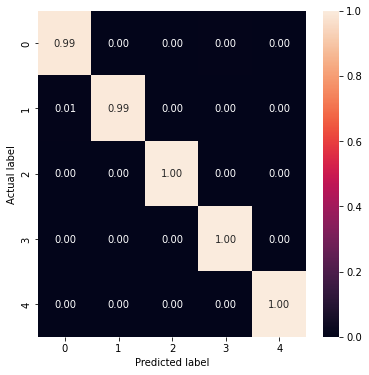

In [99]:
fig = plt.figure(figsize=(6, 6))
ax= plt.subplot()
cm = confusion_matrix(y_true=np.argmax(valy,axis=1),y_pred=np.argmax(y_pred_val,axis=1),normalize="true")
sns.heatmap(cm, annot=True, ax = ax, fmt = '.2f',)
ax.set_xlabel('Predicted label')
ax.set_ylabel('Actual label')
plt.show()

**For Testing Dataset**

In [100]:
print(classification_report(y_true=y_test,y_pred=y_pred))
f1_score_per_class_test = f1_score(y_true=y_test,y_pred=y_pred,average=None) 
print("The f1-score per class: ",f1_score_per_class_test)
print("The f1-score : ",f1_score(y_true=y_test,y_pred=y_pred,average='weighted'))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     18118
           1       0.69      0.85      0.76       556
           2       0.94      0.96      0.95      1448
           3       0.59      0.89      0.71       162
           4       0.99      0.99      0.99      1608

   micro avg       0.98      0.98      0.98     21892
   macro avg       0.84      0.93      0.88     21892
weighted avg       0.98      0.98      0.98     21892
 samples avg       0.98      0.98      0.98     21892

The f1-score per class:  [0.98697403 0.76366559 0.95133653 0.71111111 0.99003736]
The f1-score :  0.9771290400252916


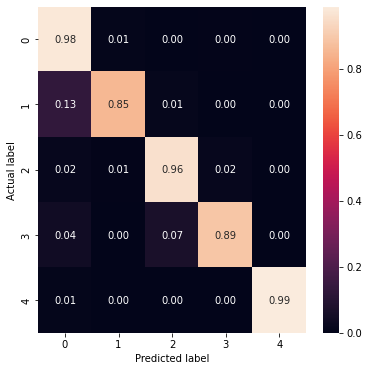

In [101]:
fig = plt.figure(figsize=(6, 6))
ax= plt.subplot()
cm = confusion_matrix(y_true=np.argmax(y_test,axis=1),y_pred=np.argmax(y_pred,axis=1),normalize="true")
sns.heatmap(cm, annot=True, ax = ax, fmt = '.2f')
ax.set_xlabel('Predicted label')
ax.set_ylabel('Actual label')
plt.show()

**Presisi Score**

In [102]:
#Validation
from sklearn.metrics import precision_score
print("The precision score : ",precision_score(y_true=valy,y_pred=y_pred_val,average='weighted'))

The precision score :  0.9964029497665488


In [103]:
#Testing
print("The precision score : ",precision_score(y_true=y_test,y_pred=y_pred,average='weighted'))

The precision score :  0.9792856642969885


**Accuracy Score**

In [104]:
#Validation
from sklearn.metrics import accuracy_score
print("The accuracy score : ",accuracy_score(y_true=valy,y_pred=y_pred_val))

The accuracy score :  0.9964


In [105]:
#Testing
print("The accuracy score : ",accuracy_score(y_true=y_test,y_pred=y_pred))

The accuracy score :  0.9759272793714598
